# Covariance Matrix

Sometimes called the [variance tensor](https://github.com/dfm/emcee/issues/306).

See:
* http://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/
* https://stats.stackexchange.com/questions/50389/a-measure-of-overall-variance-from-multivariate-gaussian/51117#51117

TODO:
* Still don't know the details about why the eigenvectors of the covariance matrix are the principal components.

In [120]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [111]:
%run ~/.jupyter/config.ipy
display(HTML("<style>.container { width:60% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Variance

We know (at least I hope) what variance is. It is a measure of how widely a set of values varies! More specifically, it is defined as:

$$
\sigma^2 = \frac{1}{N} \sum_{n=1}^{N} (v_n - \overline{v})^2
$$

$\sigma^2$ is the variance (or the variance tensor of rank 0)!

# Bessel Correction

Note that if we don't know the true (population) mean, with might need to apply the [Bessel correction](https://en.wikipedia.org/wiki/Bessel%27s_correction) where the factor infront becomes $\frac{1}{N-1}$. If we use the sample mean without this correction we will underestimate the variance. This is because, 

$$
\mu_{\text sample} \ne \mu_{\text pop}
$$

(at least not necessarily!), and (by definition) the $\mu_{\text sample}$ that we choose will be the $\mu$ that minimizes the variance of that sample.
Thus we essentially have an extra free parameter - that of the mean - when determining the variance that needs to be accounted for.

In [107]:
mu = 5
sigma = 2
n_samples = 10

samples = np.random.normal(mu, sigma, size=(100000, n_samples))

print("The estimate of the variance is low!")
print("{:.2f}".format(np.mean(np.var(samples, axis=1))))

print("The estimate of the variance is pretty good")
print("{:.2f}".format(np.mean(np.var(samples, axis=1, ddof=1))))

The estimate of the variance is low!
3.60
The estimate of the variance is pretty good
4.00


# Higher order variance and covariance

If the members of the set that we want to determine the variance of are vectors rather than numbers, a single number is not enough to fully describe how the members vary.
A single number is good enough to explain the spread on a numberline, but we now need to know how our points are distributed in $M$ dimensional space.

Mathematically,

$$
\Sigma_{ij} = \frac{1}{N} \sum_{n=1}^{N} 
    (v_{\text{n,i}} - \overline{v}_{\text{i}}) 
    (v_{\text{n,j}} - \overline{v}_{\text{j}})
$$

which is a matrix with the diagonal terms describing the variance along those axes and the off-diagonals describing the covariance between those two axes. The fact that this is symmetrical is obvious from the math, but should also make sense intuitively. If $x$ varies with $y$, then $y$ also varies with $x$.

## Covariance matrix as linear transform

Imagine we have some 2d data generated from $\mathcal{N(0, \Sigma})$ where $\Sigma$ is some matrix. what does this data set look like, and what linear transforms do we need to make to get there from white noise (unit-diagonal $\Sigma$)?

In [274]:
def _plot(a, b, eva=None, evb=None):
    _, axes = plt.subplots(1, 2, figsize=(8, 3.5))
    axes[0].scatter(a[:,0], a[:,1], s=0.1)
    axes[1].scatter(b[:,0], b[:,1], s=0.1)
    if eva:
        axes[0].plot([0, eva[1][0]], [0, eva[1][1]])
    if evb:
        axes[1].plot([0, evb[0][1][0][0]*evb[0][0]], [0, evb[0][1][0][1]*evb[0][0]], color="b")
        axes[1].plot([0, evb[1][1][0][0]*evb[1][0]], [0, evb[1][1][0][1]*evb[1][0]], color="b")
    for ax in axes:
        ax.set(xlim=(-5, 5), ylim=(-5, 5))

How to go from the left to the right?


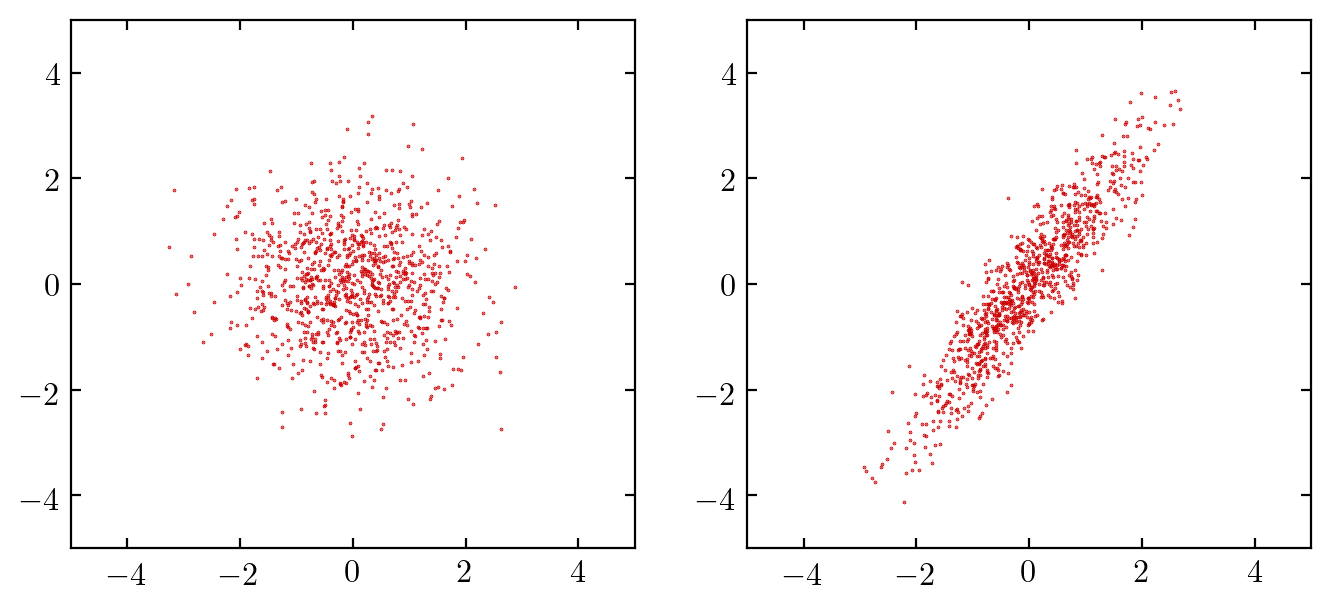

In [292]:
base_cov = np.array([[1, 0], [0, 1]])
goal_cov = np.array([[1, 1.3], [1.3, 2]])

x1 = scipy.stats.multivariate_normal(mean=[0, 0], cov=base_cov).rvs(size=(1000,))
x2 = scipy.stats.multivariate_normal(mean=[0, 0], cov=goal_cov).rvs(size=(1000,))
_plot(x1, x2)

print("How to go from the left to the right?")

Let's think of this in two steps:
* First, we need to scale the data. The data on the left has equal variance along both axis. The data on the right has an axis with more variance and one with less.
* Second, we need to rotate the data. The data on the left has no preferred orientation. The data on the right has its long axis in a particular direction.

Before we do either of these things though, we need to know by how much. In what direction is the long axis pointing? How long is the long axis? While the exact value of these is not clear from the covariance matrix (at least to me), the general idea is. The covariance matrix defines an ellipsoid with a rough length and width of the diagonal components. The shape of the distribution ranges from relatively circular if these are similar to cigarlike and then linelike as they differ by more. The covariance describes the orientation: positive means up and to the right. Negative means down and to the right.

But back to those details, of which I am still missing a few. 

The **eigenvectors** of the covariance matrix describe the orientation of the distribution and the eigenvalues the variance along those vectors. I think this has something to do with the fact that the covariance matrix is a Rayleigh quotient (see [here](./pca_sagemath.ipynb)).

We can see that in our data,

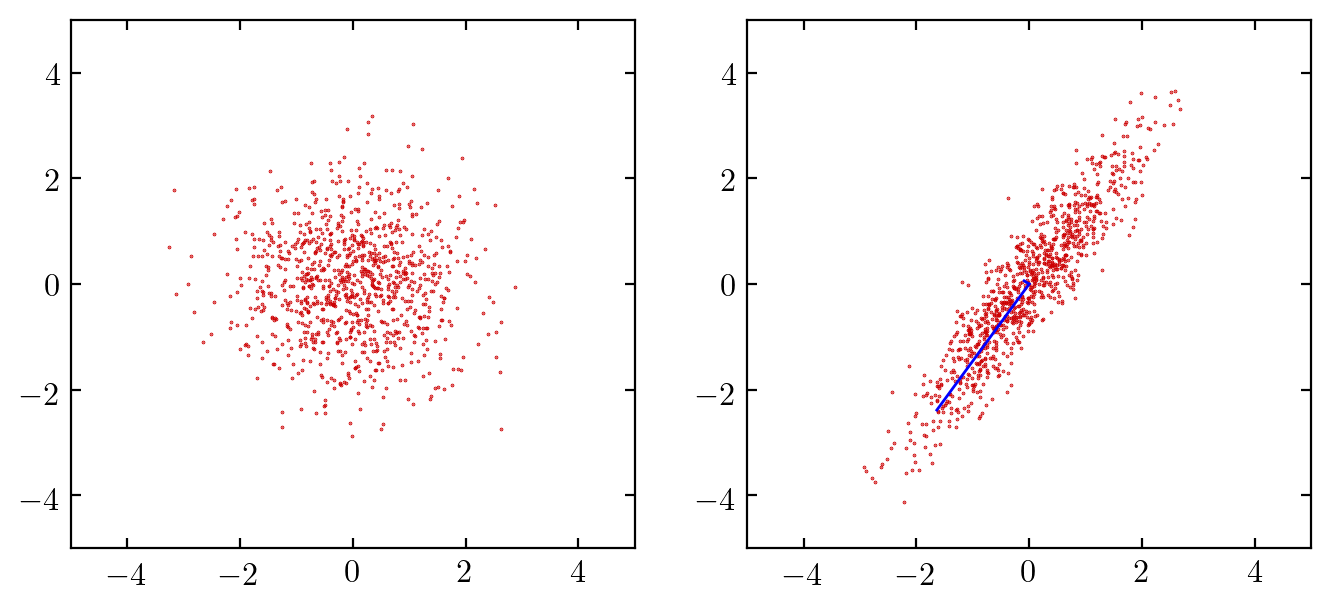

In [296]:
_plot(x1, x2, evb=matrix(goal_cov).eigenvectors_right())

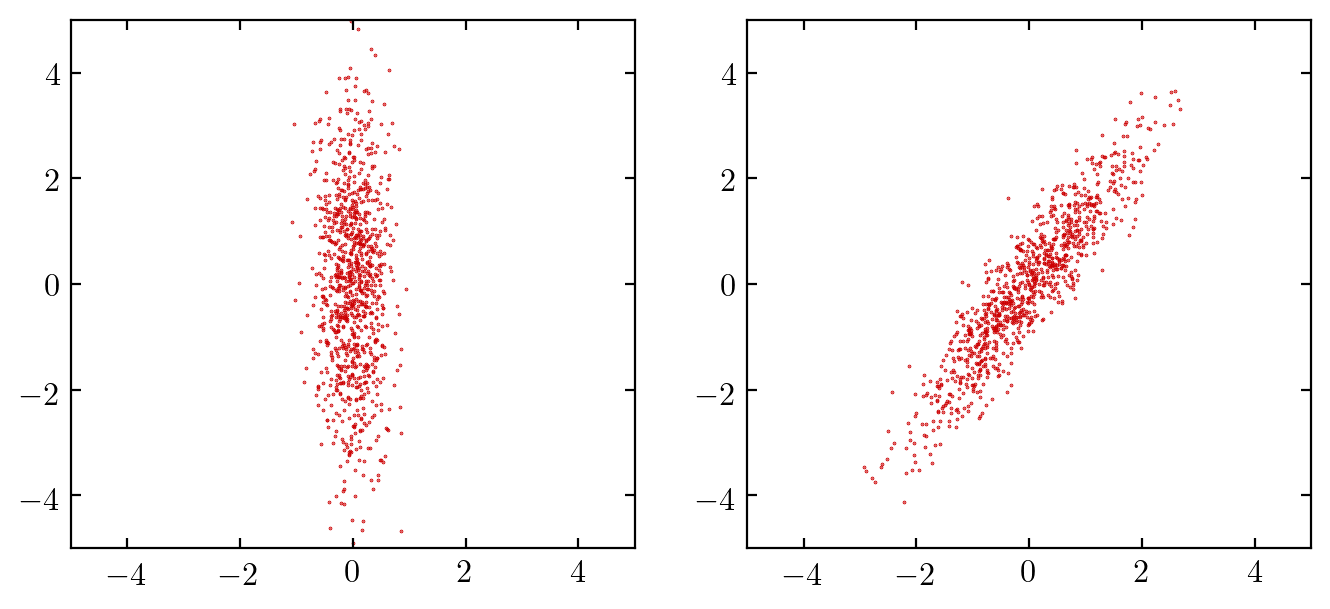

In [320]:
scale_matrix = diagonal_matrix(np.sqrt(matrix(goal_cov).eigenvalues()))
scaled_x1 = np.array(scale_matrix * matrix(x1.T)).T
_plot(scaled_x1, x2)

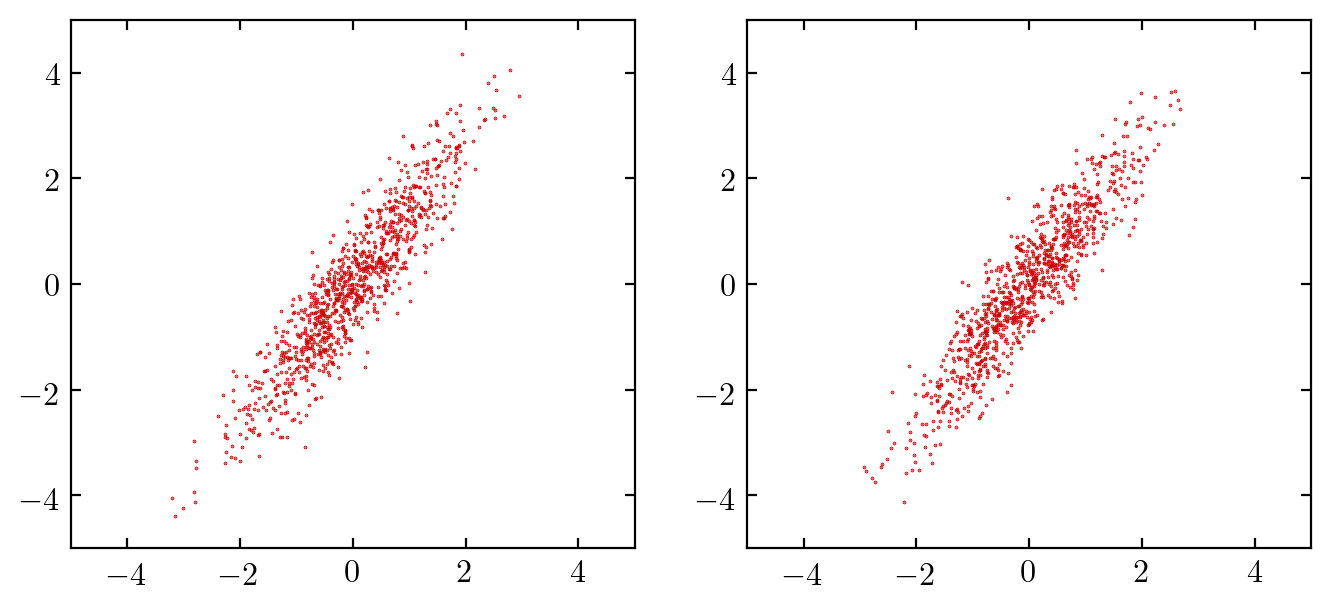

In [325]:
rot_matrix = matrix([
    vec[1][0] for vec in matrix(goal_cov).eigenvectors_right()
]).T # The columns are the eigenvectors
scaled_rotated_x1 = (rot_matrix * matrix(scaled_x1.T)).T
_plot(scaled_rotated_x1, x2)

I'm not sure why it is not quite right! it is just reflected around the axis...

## Single number summaries of higher order variance

What if we really want just a single number to describe how out data varies? There are a couple of [possibilities](https://stats.stackexchange.com/questions/50389/a-measure-of-overall-variance-from-multivariate-gaussian/51117#51117).

Maybe we don't care about direction, we just want a measure of the distance to the centroid. Well, as the diagonal terms of $\Sigma$ are the variance, which is the average squared distance from the centroid in that axis, the trace is the averaged squared distance overall.

$$
tr(\Sigma) = \Sigma_{1,1} + ... + \Sigma_{M,M} = (R - R_0)^2
$$

Maybe we are more interested in the volume that data occupies then the determinant of $\Sigma$ gives a measure of this. This is actually a nice way of checking whether your data is distributed in a hyperplane of the space! The determinant of the covariance matrix will be 0 in that case. 

# Examples

## Can your walkers explore the hyperspace?

Imagine you are running a [Goodman+Weare2010](https://msp.org/camcos/2010/5-1/p04.xhtml) ensemble sampler. In this, you set up a number of walkers and they hope over each other exploring the space. A potential issue here is that if all your walkers are initiated in a hyperplane, they can never get off it. This is bad! How can we assert that you have initialized your walkers in a way that allows them to explore the whole space.

Some trivial problems to avoid:
* You need `n_walkers > n_dim` to ensure they can explore the space (e.g. 2 points forms a line which does not cover 2d space!)

In [285]:
# Lets say we have 3 walkers in a 2 space. These are bad as they are co-linear!
bad_walkers = matrix([
    [0, 0],
    [1, 1],
    [2, 2],
])
print(bad_walkers)
# Let's put our origin in the middle of the walkers
bad_walkers = matrix(bad_walkers - np.mean(bad_walkers, axis=0))
print(bad_walkers)

[0 0]
[1 1]
[2 2]
[-1.0 -1.0]
[ 0.0  0.0]
[ 1.0  1.0]


In [288]:
cov = matrix(np.cov(bad_walkers.T))

In [291]:
print(vt.determinant())

0.0
